In [3]:
import numpy as np
from scipy.linalg import polar, sqrtm
from matplotlib import pyplot as plt
from ncon import ncon

plt.rcParams['pcolor.shading'] = "auto"
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)                 

In [29]:
def rnd(*x):
    return np.random.randn(*x) + 1j*np.random.randn(*x)

def ref(d):
    """
    Return a |000...> reference state of dimension d
    """
    s = np.zeros(d)
    s[0] = 1
    return s

def init(D=2):
    """
    Initialise random unitaries u and v of bond dimension D, \n
    returns E, M2, shifted_M2, vprj, Vr
    """
    u = ncon([polar(rnd(2*D,2*D))[0].reshape(D,2,D,2), ref(2)], [[-1,-2,-3,4], [4]])
    E = ncon([u, u.conj()], [[-1,2,-3], [-2,2,-4]]).reshape(D**2,D**2) # this is "eigen" E of shape (D,D,D,D), transpose middle indices before reshaping to get hermitian E
    M = (np.eye(D**2) - E.reshape(D**2,D**2)).reshape(D,D,D,D)
    M2 = ncon([M, M], [[7,8,-1,-4], [8,7,-2,-5]])
    shifted_M2 = (M2.reshape(D**2,D**2) - 8*np.eye(D**2)).reshape(D,D,D,D)
    Vr = np.linalg.eig(E)[1][:,np.linalg.eig(E)[0].argmax()]
    vprj = ncon([polar(rnd(D**2, D**2))[0], ref(D**2)], [[1,-1], [1]]).reshape(D, D)
    return E, M2, shifted_M2, vprj, Vr

def trace_distance(M2, v):
    """
    v.shape = (D,D)
    C = tr[(p - s)^dagger(p - s)] = tr(p^2) + tr(s^2) - 2tr(ps)
    """
    c = ncon([M2, v, v.conj(), v, v.conj()], [[3,4,6,5], [3,1], [6,1], [4,2], [5,2]])
    return c

def update(M2, v):
    """
    v.shape = (D**2,D**2)
    v <- polar(dC/dv^dagger)
    take derivative -> shape = (D,D), reshape to (D**2,), outer product to shape = (D**2,D**2)
    add up derivatives, reunitarize, project to shape = (D**2,), reshape to (D,D)
    """
    dvdag_m2v2 = np.outer(ref(D**2), ncon([M2, v, v.conj(), v], [[3,4,2,-5], [3,1], [2,1], [4,-6]]).reshape(D**2)) # derivative
    update = (ref(D**2) @ polar(dvdag_m2v2)[0]).reshape(D,D) # reunitarization

    return update

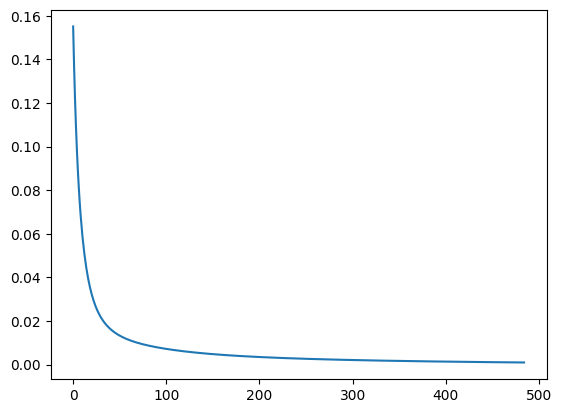


rho:
 [[ 0.11244888+1.02616987e-18j -0.00443682+5.11118349e-03j
   0.009396  +3.39477221e-02j -0.00612002+1.86042258e-03j
   0.00674604-1.27677004e-03j -0.0020002 +1.83398706e-02j
   0.00149151+2.37524225e-02j  0.01079428+1.30730572e-02j
   0.01072472+4.46728544e-03j  0.01213127-1.15549620e-02j
  -0.00720458+9.82263190e-03j]
 [-0.00443682-5.11118349e-03j  0.08889514-3.01249981e-19j
  -0.0018688 +9.24984836e-03j -0.01518798+1.77884028e-02j
   0.02288904-1.33924205e-02j  0.0165262 +1.43984592e-02j
  -0.00532177-4.82132183e-03j -0.01242768+1.08195321e-02j
  -0.00465122-3.18419582e-03j  0.01545182-1.50023124e-02j
   0.01343541+1.82178528e-02j]
 [ 0.009396  -3.39477221e-02j -0.0018688 -9.24984836e-03j
   0.09745563-7.86349487e-19j  0.005602  +4.04468664e-02j
  -0.00097604-1.49734722e-02j -0.00321115-1.07575754e-02j
   0.01608197-2.36073972e-03j -0.00403582-7.89371219e-03j
   0.00326982+9.82985154e-03j -0.01168492+2.25413548e-03j
  -0.00786156+5.51061465e-03j]
 [-0.00612002-1.86042258e-03j 

In [30]:
D = 11
E, M2, shifted_M2, vprj, Vr = init(D)

c = []
c.append(trace_distance(M2, vprj))
while c[-1] > 1e-3:
#for _ in range(10000):
    vprj = update(shifted_M2, vprj)
    c.append(trace_distance(M2, vprj))

fig = plt.figure()
plt.plot(c)
#plt.yscale("log")
plt.show()

print("\nrho:\n", ncon([vprj, vprj.conj()], [[-1,2], [-3,2]]))
print("\nsigma:\n", ncon([E.reshape(D,D,D,D), vprj, vprj.conj()], [[-1,-2,2,3], [2,4], [3,4]])) 
print("\napproximated eigenvalue:\n", np.divide(E @ ncon([vprj, vprj.conj()], [[-1,2], [-3,2]]).reshape(D**2), ncon([vprj, vprj.conj()], [[-1,2], [-3,2]]).reshape(D**2)))
print("\ntrace distance:\n", trace_distance(M2, vprj))

| D | Run Time |
| --- | ----------- |
| 2 | 0.4 |
| 4 | 0.42 |
| 8 | text |
| 16 | text |
| 32 | text |

In [70]:
def init_test(D=2):
    """
    Initialise random unitaries u and v
    """
    u = ncon([polar(rnd(2*2**int(np.log2(D)),2*2**int(np.log2(D))))[0].reshape(D,2,D,2), ref(2)], [[-1,-2,-3,4], [4]])
    assert np.allclose(ncon([u, u.conj()], [[1,2,-3], [1,2,-4]]), np.identity(2)) # unitarity condition
    E = ncon([u, u.conj()], [[-1,2,-3], [-2,2,-4]]).reshape(D**2,D**2) # this is "eigen" E of shape (D,D,D,D), transpose middle indices before reshaping to get hermitian E
    Vr = np.linalg.eig(E)[1][:,np.linalg.eig(E)[0].argmax()]
    assert np.allclose(E @ Vr, Vr)
    vprj = ncon([polar(rnd(2*2**int(np.log2(D)), 2*2**int(np.log2(D))))[0], ref(2*D)], [[1,-1], [1]]).reshape(D, 2) 

    # Dominant eigenvector found analytically minimises trace distance
    assert np.allclose(E@Vr, Vr)
    lam, U = np.linalg.eig(Vr.reshape(2,2))
    v1 = sqrtm(Vr.reshape(2,2))
    v2 = U@np.diag(np.sqrt(lam))
    p1 = ncon([v1, v1.conj()], [[-1,2], [-3,2]])
    s1 = ncon([u, u.conj(), v1, v1.conj()], [[-1,1,2], [-2,1,3], [2,4], [3,4]])
    p2 = ncon([v2, v2.conj()], [[-1,2], [-3,2]])
    s2 = ncon([u, u.conj(), v2, v2.conj()], [[-1,1,2], [-2,1,3], [2,4], [3,4]])
    assert np.allclose(p1, s1)
    assert np.allclose(p2, s2)
    assert np.allclose(trace_distance(u, v1), 0)
    assert np.allclose(trace_distance(u, v2), 0)

    return u, vprj, E, Vr
    

def trace_distance_test(u, v):
    """
    v.shape = (2,2)
    C = tr[(p - s)^dagger(p - s)] = tr(p^2) + tr(s^2) - 2tr(ps)
    """
    # preliminaries
    E = ncon([u, u.conj()], [[-1,2,-3], [-2,2,-4]]) # this is "eigen" E of shape (D,D,D,D), transpose middle indices to get hermitian E
    p = ncon([v, v.conj()], [[-1,2], [-3,2]])
    s = ncon([u, u.conj(), v, v.conj()], [[-1,1,2], [-2,1,3], [2,4], [3,4]])
    s_E = ncon([E, v, v.conj()], [[-1,-2,2,3], [2,4], [3,4]]) 
    M = (np.eye(4) - E.reshape(4,4)).reshape(2,2,2,2)
    M2 = ncon([M, M], [[7,8,-1,-4], [8,7,-2,-5]])
    assert np.allclose(ncon([M, M], [[7,8,-1,-2], [8,7,-4,-5]]), np.transpose(M2, axes=[0,2,1,3]))
    assert np.allclose(s, s_E) # sigma constructed from transfer matrix
    assert np.allclose(np.transpose(E, axes=[0,2,1,3]).reshape(4,4), np.transpose(E, axes=[0,2,1,3]).reshape(4,4).T.conj()) # transfer matrix is hermitian
    assert np.allclose(ncon([M, v, v.conj()], [[-1, -2, 1, 2], [1,3], [2,3]]), p - s)
    
    trp2 = ncon([v, v.conj(), v, v.conj()], [[1,2], [3,2], [3,4], [1,4]])

    trs2 = ncon([u, u.conj(), v, v.conj(), u, u.conj(), v, v.conj()], [[1,2,3], [4,2,5], [3,6], [5,6], [4,7,8], [1,7,9], [8,10], [9,10]])
    trs2_E = ncon([E, v, v.conj(), E, v, v.conj()], [[1,4,3,5], [3,6], [5,6], [4,1,8,9], [8,10], [9,10]]) 
    assert np.allclose(trs2, trs2_E) # tr(s^2) constructed from transfer matrix

    trps = ncon([v, v.conj(), u, u.conj(), v, v.conj()], [[1,2], [3,2], [3,4,5] ,[1,4,6], [5,7], [6,7]])
    trps_E = ncon([v, v.conj(), E, v, v.conj()], [[1,2], [3,2], [3,1,5,6], [5,7], [6,7]]) 
    assert np.allclose(trps, trps_E) # tr(ps) constructed from transfer matrix

    trace_distance = np.trace((p - s) @ (p - s).T.conj())
    assert np.allclose(np.trace((p - s) @ (p - s).T.conj()), trp2 + trs2 - 2*trps)
    assert np.allclose(np.trace((p - s_E) @ (p - s_E).T.conj()), trp2 + trs2_E - 2*trps_E)
    assert np.isclose(np.trace((p - s) @ (p - s).T.conj()), np.trace((p - s) @ (p - s)))
    assert np.isclose(np.trace((p - s_E) @ (p - s_E).T.conj()), np.trace((p - s_E) @ (p - s_E)))

    trace_distance_E = np.trace((p - s_E) @ (p - s_E).T.conj())
    assert np.allclose(trace_distance, trace_distance_E)

    trace_distance_M = ncon([M, v, v.conj(), M, v, v.conj()], [[7,8,1,2], [1,3], [2,3], [8,7,4,5], [4,6], [5,6]])
    assert np.isclose(trace_distance_M, np.trace(ncon([M, v, v.conj()], [[-1, -2, 1, 2], [1,3], [2,3]]) @ ncon([M, v, v.conj()], [[-1, -2, 1, 2], [1,3], [2,3]])))
    assert np.isclose(trace_distance_M, trace_distance)

    trace_distance_M2 = ncon([M2, v, v.conj(), v, v.conj()], [[1,4,2,5], [1,3], [2,3], [4,6], [5,6]])
    assert np.isclose(trace_distance, trace_distance_M2)

    return trace_distance

def update_test(u, v):
    """
    v.shape = (2,2)
    v <- polar(dC/dv^dagger)
    take derivative -> shape = (2,2), reshape to shape = (4,), outer product to shape = (4,4)
    add up derivatives, reunitarize, project to (4,), reshape to (2,2)
    """
    # preliminaries
    E = ncon([u, u.conj()], [[-1,2,-3], [-2,2,-4]]) # this is "eigen" E of shape (D,D,D,D), transpose middle indices to get hermitian E
    M = (np.eye(4) - E.reshape(4,4)).reshape(2,2,2,2)
    M2 = ncon([M, M], [[7,8,-1,-4], [8,7,-2,-5]])
    M2 = (M2.reshape(4,4) - 8*np.eye(4)).reshape(2,2,2,2) # shift
    assert np.allclose(np.transpose(E, axes=[0,2,1,3]).reshape(4,4), np.transpose(E, axes=[0,2,1,3]).reshape(4,4).T.conj()) # transfer matrix is hermitian

    # 1. tr(p^2) derivatives
    dvtrp2dag = np.outer(np.array([1,0,0,0]), (ncon([v.conj(), v, v.conj()], [[3,-2], [3,4], [-3,4]]) + ncon([v, v.conj(), v.conj()], [[1,2], [-3,2], [1,-1]])).reshape(4)).T.conj()
    dvdagtrp2 = np.outer(np.array([1,0,0,0]), (ncon([v, v, v.conj()], [[1,-2], [-1,4], [1,4]]) + ncon([v, v.conj(), v], [[-1,2], [3,2], [3,-4]])).reshape(4))
    dvdagtrp2_L = 2*np.outer(np.array([1,0,0,0]), ncon([v, v, v.conj()], [[1,-2], [-1,4], [1,4]]).reshape(4))
    assert np.allclose(dvdagtrp2, dvdagtrp2_L)

    # 2. tr(s^2) derivatives
    dvtrs2dag = np.outer(np.array([1,0,0,0]), (ncon([u, u.conj(), v.conj(), u, u.conj(), v, v.conj()], [[1,2,-3], [4,2,5], [5,-1], [4,7,8], [1,7,9], [8,10], [9,10]]) + 
                ncon([u, u.conj(), v, v.conj(), u, u.conj(), v.conj()], [[1,2,3], [4,2,5], [3,6], [5,6], [4,7,-8], [1,7,9], [9,-1]])).reshape(4)).T.conj()
    dvtrs2dag_E = np.outer(np.array([1,0,0,0]), (ncon([E, v.conj(), E, v, v.conj()], [[1,4,-3,5], [5,-1], [4,1,8,9], [8,10], [9,10]]) + 
                    ncon([E, v, v.conj(), E, v.conj()], [[1,4,3,5], [3,6], [5,6], [4,1,-8,9], [9,-1]])).reshape(4)).T.conj()
    assert np.allclose(dvtrs2dag, dvtrs2dag_E)
    dvdagtrs2 = np.outer(np.array([1,0,0,0]), (ncon([u, u.conj(), v, u, u.conj(), v, v.conj()], [[1,2,3], [4,2,-5], [3,-6], [4,7,8], [1,7,9], [8,10], [9,10]]) + 
                ncon([u, u.conj(), v, v.conj(), u, u.conj(), v], [[1,2,3], [4,2,5], [3,6], [5,6], [4,7,8], [1,7,-9], [8,-10]])).reshape(4))
    dvdagtrs2_E = np.outer(np.array([1,0,0,0]), (ncon([E, v, E, v, v.conj()], [[1,4,3,-5], [3,-6], [4,1,8,9], [8,10], [9,10]]) + 
                    ncon([E, v, v.conj(), E, v], [[1,4,3,5], [3,6], [5,6], [4,1,8,-9], [8,-10]])).reshape(4))
    dvdagtrs2_L = 2*np.outer(np.array([1,0,0,0]), ncon([E, v, E, v, v.conj()], [[1,4,3,-5], [3,-6], [4,1,8,9], [8,10], [9,10]]).reshape(4))
    assert np.allclose(dvdagtrs2, dvdagtrs2_E)
    assert np.allclose(dvdagtrs2, dvdagtrs2_L)

    # 3. tr(ps) derivatives
    dvtrpsdag = np.outer(np.array([1,0,0,0]), (ncon([v.conj(), u, u.conj(), v, v.conj()], [[3,-2], [3,4,5] ,[-3,4,6], [5,7], [6,7]]) + 
                ncon([v, v.conj(), u, u.conj(), v.conj()], [[1,2], [3,2], [3,4,-5] ,[1,4,6], [6,-1]])).reshape(4)).T.conj()
    dvtrpsdag_E = np.outer(np.array([1,0,0,0]), (ncon([v.conj(), E, v, v.conj()], [[3,-2], [3,-3,5,6], [5,7], [6,7]]) + 
                ncon([v, v.conj(), E, v.conj()], [[1,2], [3,2], [3,1,-5,6], [6,-1]])).reshape(4)).T.conj()
    assert np.allclose(dvtrpsdag, dvtrpsdag_E)
    dvdagtrps = np.outer(np.array([1,0,0,0]), (ncon([v, u, u.conj(), v, v.conj()], [[1,-2], [-1,4,5] ,[1,4,6], [5,7], [6,7]]) + 
                ncon([v, v.conj(), u, u.conj(), v], [[1,2], [3,2], [3,4,5] ,[1,4,-6], [5,-7]])).reshape(4))
    dvdagtrps_E = np.outer(np.array([1,0,0,0]), (ncon([v, E, v, v.conj()], [[1,-2], [-1,1,5,6], [5,7], [6,7]]) + 
                ncon([v, v.conj(), E, v], [[1,2], [3,2], [3,1,5,-6], [5,-7]])).reshape(4))
    assert np.allclose(dvdagtrps, dvdagtrps_E)

    # 4. tr((Mv)^2) derivative
    dvdagtrmv2 = np.outer(np.array([1,0,0,0]), (ncon([M, v, M, v, v.conj()], [[7,8,1,-2], [1,-3], [8,7,4,5], [4,6], [5,6]]) + 
                    ncon([M, v, v.conj(), M, v], [[7,8,1,2], [1,3], [2,3], [8,7,4,-5], [4,-6]])).reshape(4))
    dvdagtrmv2_L = 2*np.outer(np.array([1,0,0,0]), ncon([M, v, M, v, v.conj()], [[7,8,1,-2], [1,-3], [8,7,4,5], [4,6], [5,6]]).reshape(4))
    assert np.allclose(dvdagtrmv2, dvdagtrmv2_L)

    # 5. M^2v^2 derivative
    dvdag_m2v2 = 2*np.outer(np.array([1,0,0,0]), ncon([M2, v, v.conj(), v], [[1,4,2,-5], [1,3], [2,3], [4,-6]]).reshape(4))
    #assert np.allclose(dvdag_m2v2, dvdagtrmv2)

    update_full = (np.array([1,0,0,0]) @ polar(dvtrp2dag + dvdagtrp2 + dvtrs2dag + dvdagtrs2 - 2*dvtrpsdag - 2*dvdagtrps)[0]).reshape(2,2)
    update = (np.array([1,0,0,0]) @ polar(dvdagtrp2 + dvdagtrs2 - 2*dvdagtrps)[0]).reshape(2,2)
    update_E = (np.array([1,0,0,0]) @ polar(dvtrp2dag + dvdagtrp2 + dvtrs2dag_E + dvdagtrs2_E - 2*dvtrpsdag_E - 2*dvdagtrps_E)[0]).reshape(2,2)
    update_L = (np.array([1,0,0,0]) @ polar(dvdagtrp2_L + dvdagtrs2_L - 2*dvdagtrps)[0]).reshape(2,2)
    update_M = (np.array([1,0,0,0]) @ polar(dvdagtrmv2)[0]).reshape(2,2)
    update_ML = (np.array([1,0,0,0]) @ polar(dvdagtrmv2_L)[0]).reshape(2,2)
    update_M2 = (np.array([1,0,0,0]) @ polar(dvdag_m2v2)[0]).reshape(2,2)
    assert np.allclose(update, update_E)
    assert np.allclose(update, update_full)
    assert np.allclose(update, update_L)
    assert np.allclose(update, update_M)
    assert np.allclose(update, update_ML)
    #assert np.allclose(update, update_M2)

    return update_M2

C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


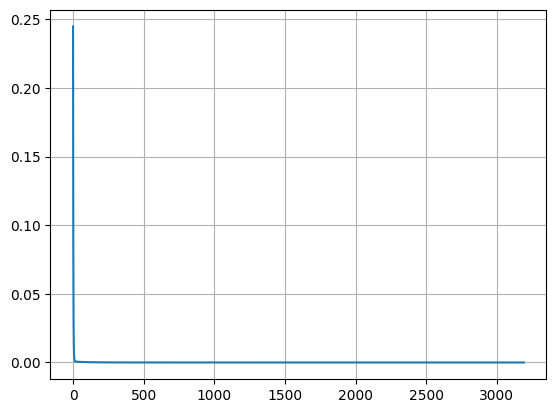


rho:
 [[0.44599901+0.j        0.21766676+0.1307435j]
 [0.21766676-0.1307435j 0.55400099+0.j       ]]

sigma:
 [[0.44599901+1.21430643e-17j 0.21766676+1.30743501e-01j]
 [0.21766676-1.30743501e-01j 0.55400099+1.73472348e-18j]]

exact eigenvector:
 [0.55978739+2.27280441e-17j 0.27320039+1.64100281e-01j
 0.27320039-1.64100281e-01j 0.69534406+0.00000000e+00j]

approximated eigenvalue:
 [1.+0.00000000e+00j 1.-7.37366884e-10j 1.+7.37366884e-10j
 1.+0.00000000e+00j]

trace distance:
 (-1.4798118330977506e-17-4.6806431912040586e-18j)

eigenspectrum of E:
 [-0.31714717-2.47419957e-01j -0.31714717+2.47419957e-01j
  1.        +4.86045013e-18j  0.75327629+1.03042475e-16j]

eigenvectors of E:
 [[-0.51856207+3.53799445e-02j  0.54109409+0.00000000e+00j
  -0.35934237+1.94354136e-01j  0.51856207-3.53799445e-02j]
 [-0.51856207-3.53799445e-02j -0.35934237-1.94354136e-01j
   0.54109409+0.00000000e+00j  0.51856207+3.53799445e-02j]
 [ 0.55978739+2.27280441e-17j  0.27320039+1.64100281e-01j
   0.27320039-1.64

In [71]:
u, vprj, E, Vr = init_test()
vprj2 = vprj

c = []
c.append(trace_distance_test(u, vprj))
while c[-1] > 1e-9:
    vprj = update_test(u, vprj)
    c.append(trace_distance_test(u, vprj))

fig = plt.figure()
plt.plot(c)
plt.grid()
plt.show()

print("\nrho:\n", ncon([vprj, vprj.conj()], [[-1,2], [-3,2]]))
print("\nsigma:\n", ncon([u, u.conj(), vprj, vprj.conj()], [[-1,1,2], [-2,1,3], [2,4], [3,4]])) 
print("\nexact eigenvector:\n", Vr)
print("\napproximated eigenvalue:\n", np.divide(E @ ncon([vprj, vprj.conj()], [[-1,2], [-3,2]]).reshape(4), ncon([vprj, vprj.conj()], [[-1,2], [-3,2]]).reshape(4)))
print("\ntrace distance:\n", trace_distance(u, vprj))
print("\neigenspectrum of E:\n", np.linalg.eig(E)[0])
print("\neigenvectors of E:\n", np.linalg.eig(E)[1].T)


rho:
 [ 0.62092155+0.j         -0.31480254-0.13830341j -0.31480254+0.13830341j
  0.37907845+0.j        ]

sigma:
 [ 0.61900291-2.77555756e-17j -0.31860516-1.38020062e-01j
 -0.31860516+1.38020062e-01j  0.38099709-2.77555756e-17j]

exact eigenvector:
 [ 0.69695117+0.00000000e+00j -0.38050534-1.49588829e-01j
 -0.38050534+1.49588829e-01j  0.42418958+1.04083409e-16j]

approximated eigenvalue:
 [0.99691002+0.j         1.00979364-0.00520276j 1.00979364+0.00520276j
 1.00506131+0.j        ]

trace distance:
 (3.6442772585266556e-05+0j)


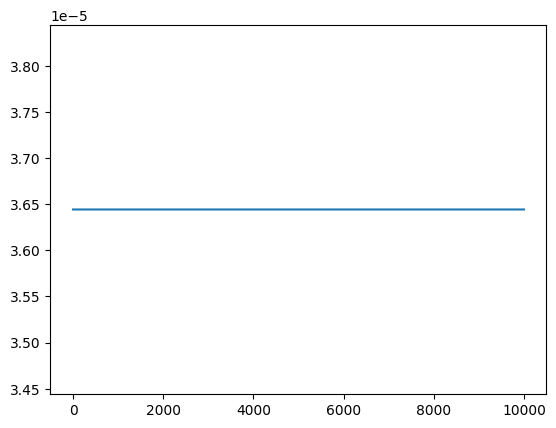

In [195]:
# stochastic optimization
c = []
eps = 1e-1024
for _ in range(10000):
    vnext = (np.array([1,0,0,0]) @ polar(np.outer(vprj2.reshape(4), np.array([1,0,0,0])) + eps*rnd(4,4))[0]).reshape(2,2)
    if trace_distance(u, vnext) < trace_distance(u, vprj2):
        vprj2 = vnext
    c.append(trace_distance(u,vprj2))

fig = plt.figure()
plt.plot(c)

print("\nrho:\n", ncon([vprj2, vprj2.conj()], [[-1,2], [-3,2]]).reshape(4))
print("\nsigma:\n", ncon([u, u.conj(), vprj2, vprj2.conj()], [[-1,1,2], [-2,1,3], [2,4], [3,4]]).reshape(4)) 
print("\nexact eigenvector:\n", Vr)
print("\napproximated eigenvalue:\n", np.divide(E @ ncon([vprj2, vprj2.conj()], [[-1,2], [-3,2]]).reshape(4), ncon([vprj2, vprj2.conj()], [[-1,2], [-3,2]]).reshape(4)))
print("\ntrace distance:\n", trace_distance(u, vprj2))

In [208]:
# check that derivative can be found via outer product
x1 = rnd(4)
x2 = rnd(4,4)
x3 = rnd(4,4)
x4 = rnd(4)
tr = ncon([x1,x2,x3,x4], [[1], [1,2], [2,3],[3]])
dx2 = ncon([x1,x3,x4], [[-1], [-2,3],[3]])
assert np.allclose(dx2, np.outer(x1, ncon([x3,x4], [[-1,2], [2]])))

In [209]:
# hermitian E
E = ncon([u, u.conj()], [[-1,2,-2], [-3,2,-4]]).reshape(4,4)
assert np.allclose(E, E.T.conj()) 
# E decomopsition
ud = sqrtm(E)
assert np.allclose(E, ncon([ud.reshape(2,2,4), ud.reshape(4,2,2)], [[-1,-2,1], [1,-3,-4]]).reshape(4,4)) # E decomposition

np.allclose(E + np.eye(*E.shape), ncon([sqrtm(E + np.eye(*E.shape)).reshape(2,2,4), sqrtm(E + np.eye(*E.shape)).reshape(4,2,2)], [[-1,-2,1], [1,-3,-4]]).reshape(4,4))

True